# Graph construction from text
### Source: https://github.com/majiga/Text2Event

This file performs following tasks:
1. extracts entities
2. extracts word-level relations between the entities
3. constructs a graph

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 21 15:30:40 2019

@author: Majigsuren Enkhsaikhan
"""
import os
import csv
import pandas as pd
import re
import json
import spacy
from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs
nlp = spacy.load("en_core_web_sm")

import networkx as nx
import matplotlib.pyplot as plt

abspath = os.path.abspath('') ## String which contains absolute path to the script file
os.chdir(abspath)

### ==================================================================================================
# Tagger
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    get_sort_key = lambda span: (span.end - span.start, span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
            seen_tokens.update(range(span.start, span.end))
    return result

# for entities
def tag_noun_chunks(doc):
    # entities
    spans = list(doc.ents)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        string_store = doc.vocab.strings
        for span in spans:
            start = span.start
            end = span.end            
            #retokenizer.merge(doc[start: end], attrs=intify_attrs({'ent_type': 'NOUN_CHUNK'}, string_store))
            retokenizer.merge(span)
    
# for verbs
def tag_chunks_spans(doc, spans, span_type):
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        string_store = doc.vocab.strings
        for span in spans:
            start = span.start
            end = span.end
            retokenizer.merge(doc[start: end], attrs=intify_attrs({'ent_type': span_type}, string_store))
            #retokenizer.merge(doc[start: end])

def clean(text):
    text = text.strip('[(),- :\'\"\n]\s*').lower()
    #text = re.sub('([A-Za-z0-9\)]{2,}\.)([A-Z]+[a-z]*)', r"\g<1> \g<2>", text, flags=re.UNICODE)
    text = re.sub('\s+', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('","', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('-', ' ', text, flags=re.UNICODE).strip()
    #text = re.sub('\(', ' ', text, flags=re.UNICODE).strip()
    #text = re.sub('\)', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('\/', ' ', text, flags=re.UNICODE).strip()
    text = text.replace("\\", ' ')
        
    text = ' '.join(text.split())
    
    if (text[len(text)-1] != '.'):
        text += '.'
    return text

def tagger(text):  
    df_out = pd.DataFrame(columns=['Document#', 'Sentence#', 'Word#', 'Word', 'EntityType', 'EntityIOB', 'Lemma', 'POS', 'POSTag', 'Start', 'End', 'Dependency'])
    #corefs = []
    text = clean(text)
    
    nlp = spacy.load("en_core_web_sm")
    ruler = EntityRuler(nlp, overwrite_ents=True)
    
    # Read JSON file
    with open('VOCABULARY_TYPED.json', encoding="utf8") as data_file:
        patterns = json.load(data_file)

    ruler.add_patterns(patterns)
    nlp.add_pipe(ruler)

    document = nlp(text)
    
    annotation = []
    #print('Spacy NLP before chunking \n')
    for token in document:
        #print(token.text, token.ent_type_)
        if token.ent_type_ in ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']:
        #print([token.i, token.text, token.ent_type_, token.ent_iob_, token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_])
            annotation.append([token.text, token.ent_iob_ + '-' + token.ent_type_]) #, token.pos_, token.tag_]) 
            #print(token.text, token.ent_iob_ + '-' + token.ent_type_)
        else:
            annotation.append([token.text, 'O'])
            #print(token.text, 'O')
    #print('\n\n\n')
    
    # Chunk entities
    tag_noun_chunks(document)    
    
    # Chunk verbs with multiple words: 'were exhibited'
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_left.pos_ == 'VERB' and w_right.pos_ == 'VERB' and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk verbs
    spans_change_verbs = []
    for i in range(2, len(document)):
        w_left = document[i-2]
        w_middle = document[i-1]
        w_right = document[i]
        if w_left.ent_type_ == 'ADP' and w_middle.ent_type_ == 'VERB' and w_right.ent_type_ == 'ADP' and w_left.ent_type_ != 'NOUN_CHUNK' and w_middle.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk verbs
    spans_change_verbs = []
    for i in range(2, len(document)):
        w_left = document[i-2]
        w_middle = document[i-1]
        w_right = document[i]
        if w_left.ent_type_ == 'VERB' and w_middle.ent_type_ == 'PART' and w_right.ent_type_ == 'ADP' and w_left.ent_type_ != 'NOUN_CHUNK' and w_middle.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk: adp + verb; part  + verb
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_right.pos_ == 'VERB' and (w_left.pos_ == 'ADP' or w_left.pos_ == 'PART')  and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk: verb + adp; verb + part 
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_left.pos_ == 'VERB' and (w_right.pos_ == 'ADP' or w_right.pos_ == 'PART')  and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk verbs with multiple words: 'were exhibited'
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_left.pos_ == 'VERB' and (w_right.pos_ == 'VERB') and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    for i in range(1, len(document)):
        w_single_verb = document[i]
        if w_single_verb.pos_ == 'VERB' and w_single_verb.ent_type_ == '':
            spans_change_verbs.append(document[w_single_verb.i : w_single_verb.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # chunk all between LRB- -RRB- (something between brackets)
    start = 0
    end = 0
    spans_between_brackets = []
    for i in range(0, len(document)):
        if ('-LRB-' == document[i].tag_ or r"(" in document[i].text):
            start = document[i].i
            continue
        if ('-RRB-' == document[i].tag_ or r')' in document[i].text):
            end = document[i].i + 1
        if (end > start and not start == 0):
            span = document[start:end]
            try:
                assert (u"(" in span.text and u")" in span.text)
            except:
                pass
                #print(span)
            spans_between_brackets.append(span)
            start = 0
            end = 0
    tag_chunks_spans(document, spans_between_brackets, '')
    
    ignore_entities = ['drill', 'ltd', 'limited', 'pty', 'company', 'project', 'prospect', 'hole', 'twin', 'impregnate', 'core']
    noun_chunks = []
    doc_id = 0
    count_sentences = 0
    #print("Some Rules to ignore some entities are performed.\n\n")
    for token in document:
        #print(len(document), token.i)
        if (token.text == '.'):
            count_sentences += 1
        elif (token.ent_type_ != '' and token.ent_type_ != 'VERB_CHUNK'):
            noun_chunks.append(token)
        if token.tag_ == 'CD' or token.ent_type_ == 'CARDINAL' or token.ent_type_ == 'QUANTITY':
            #print(token, token.tag_)
            df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, '', '', token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
        elif (len(document) > token.i + 1):
            #print(token.text, token.i, doc[token.i+1].text, token.i + 1)            
            if (bool([w for w in ignore_entities if(w in document[token.i+1].text)])):
                df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, '', '', token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
            else:
                df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, token.ent_type_, token.ent_iob_, token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
        else:
            df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, token.ent_type_, token.ent_iob_, token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
    
    #print("ENTS\n", len(document.ents), '\n', document.ents, '\n\n')
    
    return df_out, document.ents, document, annotation #, words_ids #noun_chunks

### ==================================================================================================
### triple extractor

def get_sentences(df_text):
    sentences = []
    aSentence = []
    
    for index, row in df_text.iterrows():
        d_id, s_id, word_id, word, ent, ent_iob, lemma, cg_pos, pos, start, end, dep = row.items()
        
        #if 'VERB_CHUNK' == ent[1] or (('ADP' in cg_pos[1] or 'VERB' in cg_pos[1]) and ent[1] == ''):
        if 'VERB_CHUNK' == ent[1] or (('ADP' in cg_pos[1] or 'VERB' in cg_pos[1]) and ent[1] == ''):
            aSentence.append([word[1], word_id[1], 'VERB_CHUNK'])
        #elif 'obj' in dep[1]:
        #    aSentence.append([word[1], word_id[1], 'object'])
        elif ent[1] != '' and ent[1] != 'VERB_CHUNK':
            aSentence.append([word[1], word_id[1], ent[1]]) # 'NOUN_CHUNK'
        elif word[1] == '.':
            aSentence.append([word[1], word_id[1], '.'])
            sentences.append(aSentence)
            aSentence = []
        else:
            #aSentence.append([word[1], word_id[1], pos[1]])    
            aSentence.append([word[1], word_id[1], ''])
    
    #print('\n', sentences, '\n')
    return sentences

def get_predicate(s):
    pred_ids = {}
    for w, index, spo in s:
        #print(s)
        if spo == 'VERB_CHUNK' and w != "'s":
            pred_ids[index] = w
    predicates = {}
    for key, value in pred_ids.items():
        predicates[key] = value
    #print(predicates)
    return predicates

def get_positions(s, start, end):
    adps = {}
    #print(start, end)
    for w, index, spo in s:
        #print(w, index, spo)
        if index >= start and index <= end and not (spo == '' or spo == '.' or spo == 'VERB_CHUNK'):
            #print(index)
            adps[index] = w
    #print('adps = ', adps, '\n')
    return adps

### ==================================================================================================
def extract_sentence_triples(df_text):
    sentences = get_sentences(df_text)
    sentence_relations = {}
    #count = 0
    # FOR EACH SENTENCE
    for s in sentences:
        if len(s) == 0: 
            continue
        
        relations = []
        preds = get_predicate(s) # Get all verbs
        #print("\nPreds = ", preds, '\n')
        
        raw_sent = ' '.join(list(zip(*s))[0]) # get the raw sentence
        #print(raw_sent, '\n')
        if preds:
            if (len(preds) == 1):
                #print("preds = ", preds)
                predicate = list(preds.values())[0]
                #print("predicate = ", predicate)
                #if (len(predicate) < 2):
                #    predicate = 'is'
                #print(s)
                ents = [e[0] for e in s if e[2] != '' and e[2] != '.' and e[2] != 'VERB_CHUNK']
                #print('ents = ', ents)
                for i in range(1, len(ents)):
                    relations.append([ents[0], predicate, ents[i]])
                    #print('1 - ', relations, '\n')

            pred_ids = list(preds.keys())
            pred_ids.append(s[0][1])
            pred_ids.append(s[len(s)-1][1])
            pred_ids.sort()
                    
            for i in range(1, len(pred_ids)-1):                
                predicate = preds[pred_ids[i]]
                #print('---- predicate = ', predicate)
                
                adps_subjs = get_positions(s, pred_ids[i-1], pred_ids[i])
                #print('- subjects = ', adps_subjs)
                adps_objs = get_positions(s, pred_ids[i], pred_ids[i+1])
                #print('- objects = ', adps_objs)
                
                for k_s, subj in adps_subjs.items():                
                    for k_o, obj in adps_objs.items():
                        obj_prev_id = int(k_o) - 1
                        if obj_prev_id in adps_objs: # at, in, of
                            #relations.append([subj, predicate + ' ' + adps_objs[obj_prev_id], obj, raw_sent])
                            relations.append([subj, predicate, obj])
                            #print('2 - ', relations, '\n')
                        else:
                            relations.append([subj, predicate, obj])
                            #print('3 - ', relations, '\n')
        sentence_relations[raw_sent] = relations
        #count += 1
        
    #print("RELATIONS by Sentence\n", sentence_relations)
    return sentence_relations
       
def extract_triples_by_sentences(text):
    remove_words = ['a', 'an', 'the', 'its', 'their', 'his', 'her', 'our', 'who', 'that', 'this', 'these', 'those']
    df_tagged, entities, doc, annotation = tagger(text)
    
    #extract_relations(doc)    
    sentence_triples = extract_sentence_triples(df_tagged)
    
    Sent_Triples = {}
    for raw_sentence, triples in sentence_triples.items():        
        filtered_triples = []
        for s, p, o in triples:
            if s == o:
                continue            
            subj = s.strip('[,- :\'\"\n]*')
            pred = p.strip('[- :\'\"\n]*.')
            obj = o.strip('[,- :\'\"\n]*')
            
            subj = ' '.join(word for word in subj.lower().split() if not word in remove_words)
            obj = ' '.join(word for word in obj.lower().split()  if not word in remove_words)
            subj = re.sub("\s\s+", " ", subj)
            obj = re.sub("\s\s+", " ", obj)
            
            if subj and pred and obj:
                filtered_triples.append([subj, pred, obj])
        Sent_Triples[raw_sentence] = filtered_triples

    Sent_Entities = []
    
    #print('\nENTITIES:\n')
    for e in set(entities):
        entity = ' '.join(word for word in e.text.lower().split() if not word in remove_words)
        Sent_Entities.append(entity)
    
    return Sent_Triples, df_tagged, entities, doc, annotation # Sent_Entities

def get_graph(triples):
    G = nx.DiGraph()
    for s, p, o in triples:
        G.add_edge(s, o, label=p)
    return G

def draw_graph_centrality(G):    
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    
    plt.figure(figsize=(15,8))
    pos = nx.spring_layout(G)
    #print("Nodes\n", G.nodes(True))
    #print("Edges\n", G.edges())
    nx.draw_networkx_nodes(G, pos, 
            nodelist=degree_dict.keys(),
            with_labels=False,
            edge_color='black',
            width=1,
            linewidths=1,
            node_size = [v * 100 for v in degree_dict.values()],
            node_color='blue',
            alpha=0.3)
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    #print(edge_labels)
    nx.draw_networkx_edge_labels(G, pos,
                           font_size=9,
                           edge_labels=edge_labels,
                           font_color='red')
    nx.draw(G, pos, with_labels=True, node_size=1, node_color='blue')

def draw_graph(G):
    plt.figure(figsize=(12,10))
    pos = nx.spring_layout(G)
    #print("Nodes\n", G.nodes(True))
    #print("Edges\n", G.edges())
    
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    #print(edge_labels)
    nx.draw_networkx_edge_labels(G, pos,
                           font_size=10,
                           edge_labels=edge_labels,
                           font_color='blue')
    nx.draw(G, pos, with_labels=True, node_size=4, node_color='blue')

# Synonyms and Abbreviations are siolved using a list in synonyms.csv file

def resolve_synonyms(g):
    synonyms = {}
    with open("synonyms.csv", 'r', encoding='latin1') as f:        
        reader = csv.reader(f, delimiter=',')
        for row in reader:            
            synonyms[row[0].lower()] = row[1].lower() # abbreviation and exact words
    #print('synonyms # : ', synonyms)
    
    remove_nodes = []
    add_edges = []
    add_nodes = []

    #print('Resolve synonym before:\n', nx.info(g))

    for s, t, data in g.edges(data=True):
        #if s not in remove_nodes:
            if s in synonyms.keys():
                if synonyms[s] not in g.nodes():
                    add_nodes.append([synonyms[s], g.node[s]])
                add_edges.append([synonyms[s], t, data['label']])
                #print('add_edge: ', [synonyms[s], t, data['label']])
                if s not in remove_nodes:
                    remove_nodes.append(s)
        #if t not in remove_nodes:
            if t in synonyms.keys():
                if synonyms[t] not in g.nodes():
                    add_nodes.append([synonyms[t], g.node[t]])
                add_edges.append([s, synonyms[t], data['label']])
                #print('add_edge: ', [s, synonyms[t], data['label']])
                if t not in remove_nodes:
                    remove_nodes.append(t)
    
    # deal with unconnected nodes
    for n, data in g.nodes(data=True):
        if n not in remove_nodes:
            if n in synonyms.keys():
                if synonyms[n] not in g.nodes():
                    add_nodes.append([synonyms[n], g.node[n]])
                remove_nodes.append(n)
                
    for n, data in add_nodes:
        #print('add node: ', n, data)
        g.add_node(n, group=data['group'])
    
    for s, t, d in add_edges:
        #print('add egde: ', s, t, d)
        g.add_edge(s, t, label=d)
    
    if len(remove_nodes) > 0:
        #print('Synonyms are found. Remove nodes : ', remove_nodes)
        for n in remove_nodes: # remove the merged nodes
            if n in g.nodes():
                g.remove_node(n)
    
    #print('Resolve synonym after:\n', nx.info(g))
    return g    

def build_graphs(triples, entities):
    G = nx.DiGraph()
    ents = {e.text: e.label_ for e in entities}
    
    for s, p, o in triples:
        #print(s, p, o)
        # create a node
        if (s not in G.nodes()):
            #print('\n\n', ents[o])
            G.add_node(s, group=ents[s])
        if (o not in G.nodes()):
            G.add_node(o, group=ents[o])
        #print(s, p, o)
        if G.has_edge(s, o):
            current_labels = G[s][o]['label'].split(',')
            #print(current_labels)
            if p.strip() not in current_labels:
                G.add_edge(s, o, label=G[s][o]['label'] + ',' + p)
        else:
            G.add_edge(s, o, label=p)
    
    #print(G.nodes(True))
    return G, ents

# Create a graph file from a given graph
def create_graph_file(g, filename):
    # Add degree
    degree_dict = dict(g.degree(g.nodes()))
    nx.set_node_attributes(g, degree_dict, 'degree')

    # Save graph files
    nodes = [{'id': n, 'group': g.node[n]['group'], 'degree': g.node[n]['degree']} for n in g.nodes()]
    links = [{'source': u, 'target': v, 'label': d['label']} for u, v, d in g.edges(data=True)]
    with open(filename, 'w') as f:
        json.dump({'nodes': nodes, 'links': links}, f, indent=4,)

In [2]:
def text2graph(text):
    Sent_Triples, df, entities, doc, annotation = extract_triples_by_sentences(text)
    """
    for index, row in df.iterrows():
        _, s, i, w, ent, iob, l, pos, tag, s, e, dep = row
        print(i, '\t', w, '\t', ent, '\t', s, '\t', e)
    """
   
    #print("\n\nEntities:", len(entities), "\n")
    #for e in entities:
    #    print(e, e.label_, e.start, e.end)
        
    triples = []
    #print('\n\nSentence # = ', len(Sent_Triples))
    for k,v in Sent_Triples.items():
        #print('\n', k)
        triples += v
        #for val in v:
        #    print(val)        
    #print("Triples\n", len(triples))
    
    g, ents = build_graphs(triples, entities)    
    
    #print("\n------ SYNONYMS resolving on the graph ... ")
    M = resolve_synonyms(g)
    
    #print("\n------ SELF LOOP removal on the graph ... \n")
    M.remove_edges_from(M.selfloop_edges())    
    
    return M, annotation, doc

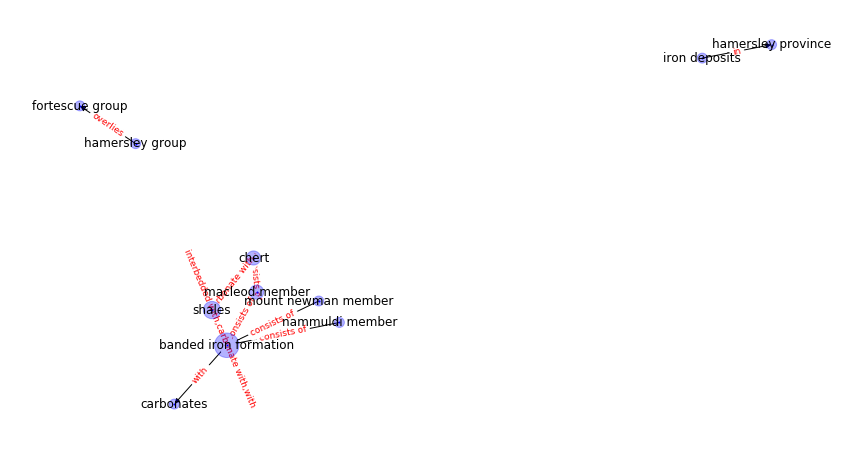

In [3]:
# a075345_c125_2004_2007a_14419765.json
text = """The Hamersley Group (approximately 2450-2630 Ma) conformably overlies the Fortescue Group and is about 2,500m thick.
The Hamersley Group consists of a sequence of banded iron formations (BIF), dolomites, pyroclastic\/hemipelagic shale, and acid volcanic rocks and has been intruded by dolerite sills and dykes.
The MMIF, particularly in its upper section, is host to major iron deposits in the Hamersley Province.
The formation consists of 3 members: The lowermost Nammuldi Member (~80m thick) consists of cherty BIF interbedded with thin shales.
The MacLeod Member (~75m thick) consists of BIF, chert and carbonate with numerous interbedded shales and several prominent podded BIF horizons which provide marker horizons invaluable in field mapping.
The upper Mount Newman Member (~65m thick) consists of more typical BIF with interbedded carbonates and shales."""

g, annotation, document = text2graph(text)
draw_graph_centrality(g)

# Build a D3.JS graph
create_graph_file(g, 'graph.json')

In [4]:
displacy.render(document, style="ent")

In [5]:
# print graph edges (source node, target node, relations)
print(*g.edges(data=True), sep='\n')

('hamersley group', 'fortescue group', {'label': 'overlies'})
('iron deposits', 'hamersley province', {'label': 'in'})
('nammuldi member', 'banded iron formation', {'label': 'consists of'})
('shales', 'banded iron formation', {'label': 'podded'})
('macleod member', 'chert', {'label': 'consists of'})
('macleod member', 'banded iron formation', {'label': 'consists of'})
('chert', 'shales', {'label': 'carbonate with'})
('mount newman member', 'banded iron formation', {'label': 'consists of'})
('banded iron formation', 'shales', {'label': 'interbedded with,carbonate with,with'})
('banded iron formation', 'carbonates', {'label': 'with'})
